# Importando bibliotecas

In [ ]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import time
from datetime import datetime
from torch import nn  # Import the neural network module from PyTorch
import gym
from gym import spaces
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.utils import resample
import sys
import os
sys.path.append(os.path.join('..'))
from classes._exploration import exploration
from classes._Env3WGym import Env3WGym
from classes._LoadInstances import LoadInstances
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel

In [ ]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' or 'PPO', 'RNA' 
    
    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:

            directory = f'..\\..\\logs\\{event_name}'
            path_dataset = '..\\..\\..\\dataset'   
            path_model = f'..\\models\\{event_name}\\{model_type}'  

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            if not os.path.exists(path_model):
                os.makedirs(path_model)                
            
                    
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            log_filename = f'{directory}\\{current_time}_{event_name}_{model_type}-log.txt'
            # Configuração do Logging
            logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')

            instances = LoadInstances(path_dataset)
            
            logging.info(f'Iniciando carregamento do dataset')
            dataset = instances.load_instance_with_numpy(events_names)    
            logging.info(f'Fim carregamento do dataset')
            
            logging.info(f'Iniciando divisão do dataset em treino e teste')
                
            # Definindo a porcentagem para divisão entre treino e teste
            train_percentage = 0.8  # 80% para treino

            dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

            if model_type == 'DQN':
                logging.info(f'Iniciando treinamento do algoritmo DQN')    
                start_time = time.time()
                agente = Agent(path_model)
                agente.env3W_dqn(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo DQN')


                logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
                accuracy, model_agent = agente.env3W_dqn_eval(dataset_test_scaled, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
                logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')
                
            elif model_type == 'PPO':      
            
                start_time = time.time()
                agente = Agent(path_model)
                agente.env3W_ppo(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento {model}: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento {model}: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo {model}')

                logging.info(f'Iniciando avaliação do algoritmo {model} conjunto de teste')
                accuracy, model_agent = agente.env3W_ppo_eval(dataset_test_scaled, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando {model}')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando {model}')
                logging.info(f'Fim avaliação  do algoritmo PPO conjunto de teste')
            
            elif model_type == 'RNA':
                logging.info(f'Iniciando treinamento do modelo RNA')  
                
                supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
                start_time = time.time()
                model_agent = supervised.keras_train()  
                print(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do modelo RNA')

                logging.info(f'Iniciando avaliação do modelo RNA conjunto de teste')
                accuracy = supervised.keras_evaluate()
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando RNA')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando RNA')
                logging.info(f'Fim avaliação  do modelo RNA conjunto de teste')

            logging.info(f'Iniciando a validação do modelo {model_type}') 
            validation = ValidationModel(model_type, event_name)

            validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type} para o evento {event_name}')
   

### Testando novo modelo de ambiente para detecção de Aumento Abrupto de BSW

In [1]:
from sklearn.preprocessing import StandardScaler
import sys
import os
sys.path.append(os.path.join('..'))
from classes._Env3WGym_copy import Env3WGym
from classes._LoadInstances import LoadInstances
import numpy as np

path_dataset = '..\\..\\..\\dataset' 

events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

event_name = [value for key, value in events_names.items() if key != 0][0]  

instances = LoadInstances(path_dataset)

_, array_list = instances.load_instance_with_numpy(events_names)

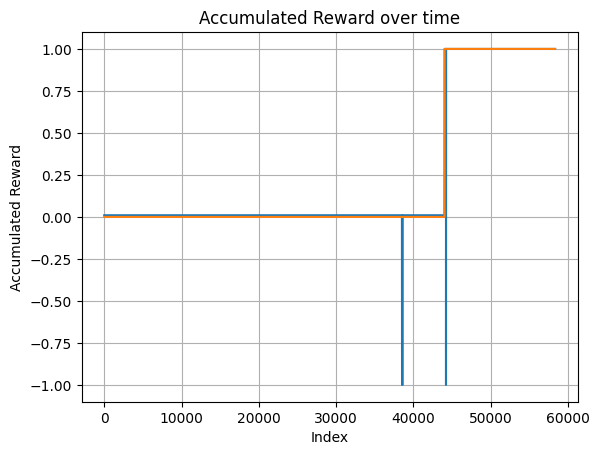

In [2]:
# Step 1: Concatenate the numerical part of all arrays, excluding the timestamp
# Assuming each sub-array has the same number of numerical features
numerical_data = [sub_array[:, 1:-1].astype(float) for sub_array in array_list]  # Convert to float
numerical_data_concatenated = np.concatenate(numerical_data, axis=0)

# Step 2: Normalize the numerical data
scaler = StandardScaler()
scaler.fit(numerical_data_concatenated)
array_list_scaled = [scaler.transform(sub_array[:, 1:-1].astype(float)) for sub_array in array_list]

# Now you have a list of scaled sub-arrays without the timestamps.
# If you need to reattach the timestamps, you can do so after scaling.

# Prepare your environment with the scaled data
# Here, you'll need to ensure the Env3WGym class can handle the scaled data correctly.
env = Env3WGym(array_list_scaled)

# Run the environment loop
obs = env.reset()
acc_reward = []
index = 0
acc_action = []
for i in range(len(array_list_scaled[0])):

    if array_list[0][index, -1] == 0:
        action = 0
    else:
        action = 1
    
    acc_action.append(action)
    obs, reward, done, info = env.step(action)
    acc_reward.append(reward)
    index += 1
    
    if done:
        obs = env.reset()


# plot the acc_reward (axis y) and index (axis x)
        
import matplotlib.pyplot as plt

plt.plot(acc_reward)
plt.plot(acc_action)
plt.xlabel('Index')
plt.ylabel('Accumulated Reward')
plt.title('Accumulated Reward over time')
plt.grid()
plt.show()




In [ ]:
logging.info(f'Iniciando treinamento do algoritmo DQN')    
start_time = time.time()
agente = Agent(path_model)
agente.env3W_dqn(dataset_train_scaled, n_envs = 5)  
print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
logging.info(f'Fim treinamento do algoritmo DQN')


logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
accuracy, model_agent = agente.env3W_dqn_eval(dataset_test_scaled, n_envs = 1)
print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')